# Understanding and Identifying Fake News


### Brief Intro

'Fake News' is a colloquialism for misinformation that means many things to many different people.

The idea of what 'Fake News' represents can be different depending on who you ask and what their political or apolitical alignment is; regardless of charged cultural context, misinformation, and the ability for it to rapidly spread, is a pressing concern for our internet-centric society.

Whether it be a TikTok of a man drinking cranberry juice from the jug while skateboarding set to a backdrop of Fleetwood Mac's "Dreams', or inflammatory and untrue information, the ability for anything to prolifically spread within a matter of minutes on the Internet means that people's perceptions of things can rapdily change, sometimes to disastrous consequences. Traditional and human means of monitoring are simply not possible with the speed at which information can spread on the internet, especially considering the many platforms and users by which even something as innocuous as a kitten gif can be posted.

Therefore, it is important to develop automated means of identifying 'Fake News', and furthermore, to understand what underlies Fake News. Ths boils down to a few simple questions.

Of course, I say important, but this is obviously a student project, and represents more of my own personal curiosity and desire to better understand machine text reading and fake news than something deeply profound or unique.

### Core Questions

1. What does Fake News look like?
2. What are typical characteristics of Fake News? (Common or frequent words)
3. What are typical characteristics of 'normal' news? (Common or frequent words)
4. Can we identify and predict Fake News? (Logistic Regression model)

## Dataset

To answer my questions, I used a dataset from Kaggle.

The dataset can be found here: https://www.kaggle.com/datasets/jillanisofttech/fake-or-real-news/code

It was a fairly simple set of data of what looked to be news articles, tweets, and other social media posts. The columns provided were number (an index field?), title, text, and label determining the text as 'FAKE' or 'REAL'.

I decided in this case to use pre-labeled data to approach the problem in a supervised manner because I also wished to look at characteristics of fake news myself.

In [1]:
# Import all the libraries
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


### Setting up smaller dataset

The original dataset was 30 MB.

The project limited datasets to 10 MB, so I decided to sample the data and pull 32% of the data into a new CSV file.

This is the code detailing this. This block of code is not run as this needed to be performed only once, and could call an error if you do not have access to the original dataset.

What I did was first I read in the data, sampled 32% of it using data.sample, exported the data as a CSV, and then checked the file size to make sure it was within the project requirements.

In [2]:
# Reload dataframe
# START RUNNING FROM HERE
data = pd.read_csv('data.csv', usecols= ['title','text','label'])

### Quick look into data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   2027 non-null   object
 1   text    2027 non-null   object
 2   label   2027 non-null   object
dtypes: object(3)
memory usage: 47.6+ KB


In [4]:
data.head()

,title,text,label
0,CAN IT GET MORE CORRUPT? Bill That Bans Naming...,Editor’s Note : Disgusting. This country just ...,FAKE
1,Why Hillary Won't Unleash WWIII : Information,Why Hillary Won't Unleash WWIII By Pepe Escob...,FAKE
2,GOP elites are now resigned to Donald Trump as...,"Throughout the Republican Party, from New Hamp...",REAL
3,Democratic debate: 5 takeaways - Politics.com,Miami (CNN) There were few softballs Wednesday...,REAL
4,"In a revealing interview, Trump predicts a ‘ma...",Donald Trump said in an interview that economi...,REAL


In [5]:
data.shape

(2027, 3)

In [6]:
data.isnull().sum()

title    0
text     0
label    0
dtype: int64

Luckily, our data has no null values.

In [7]:
#data['label'] = data['label'].astype(str)
#data['label'].replace(['REAL','FAKE'],
#                        [0, 1], inplace=True)
#data['label']
#data['label']

### Visualizing distribution of FAKE/REAL Labels

REAL    1023
FAKE    1004
Name: label, dtype: int64


<AxesSubplot:xlabel='label', ylabel='count'>

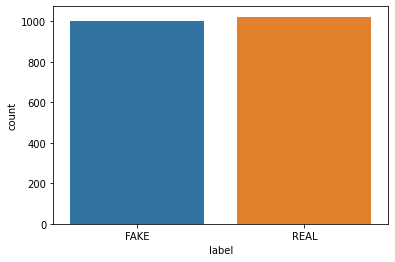

In [8]:
print(data['label'].value_counts())
# We need to 'melt' the data a bit to get an easy plot.
data['count'] = data.groupby('label')['label'].transform('count')
sns.barplot(x="label", y="count", data=data)

# We have a relatively even enough split.

We have a relatively even distribution of labels, so there's no problem with one label being more weighted than the other.

#### Split Data

Given that we are looking to train a model, we want to split the data into training and testing data. Reading over scikitlearn's documentation for its feature extraction module, it seems a 'corpus', or dictionary of words, is built form the data you use. I imagine this may introduce errors or issues if the 'built' vectorized wordset comes across words it didn't have or is unable to find words it should have should there be subtle differences between training/test data. So we'll want to split the data here.

In this case, we use 'text' as the predictors. The headlines are often just the first few lines of the text. Could it have been relevant? Sometimes, but I felt it was less valuable given the shorter length of the text. My interest is also particularly in the written sentences of posts/articles themselves.

I use the train/test split function from here:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
#y = data['label']
#X = data['text']
training_data, testing_data = train_test_split(data, test_size=0.3, random_state=1)
# GET LABELS
y_train=training_data['label']
y_test=testing_data['label']
#X_train.shape

## Cleaning, Processing, some more EDA

The vectorizer in scikitlearn will perform much faster than anything I could write to count individual words, which is important given that there are >2000 entries, with some individual entries being about as big as the ipsum lorem text we needed to process.

In this case, scikitlearn provides quite a few automated tools to 'tokenize' and count words.

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

What's cool about this is that it stores in CSR format. Perhaps with more time and familiarity, this is something I could've coded myself to both speed up analysis and reduce storage needs.

I utilized CountVectorizer. According to scikit-learn documentation, CountVectorizer both extracts features into 'tokens' (representations for words) and counts them at the same time.

Doing this achieves the same thing that we performed in class through regular expressions and processing python string, but also adds the benefit of the later functions we created to count word occurences, while also treating certain words and their 'extensions' (kill and killing, for example), as individual words.

In [10]:
# Clean Data
vectorizer = CountVectorizer(stop_words='english',analyzer='word')
train_vec = vectorizer.fit_transform(training_data['text'].values)
train_vec

<1418x33843 sparse matrix of type '<class 'numpy.int64'>'
	with 376249 stored elements in Compressed Sparse Row format>

As we learned in class, unprocessed text data can be messy. 
This is especially the case for tweets, online articles, and other social media posts. I initially believed CountVectorizer would also clean the text (as it splits words), but it sadly doesn't, as you'll see.

As per scikitlearn documentation, it takes 'words' of 2 alphanumerics or more only. I also specified 'stop_words = 'english' to cut out the aforementioned unimportant words like 'and' and 'or'.

Let's take a quick peep at what came out.

In [11]:
# Let's take a quick look

features = vectorizer.get_feature_names_out() #Shows word tokens
print(features)

#Right away we see there are a few anomalies (numbers), including russian and what appears to be arabic.

['00' '000' '000000031' ... 'октября' 'русский' 'عربي']


Right away we see there are a few anomalies (numbers), including russian and what appears to be arabic.
I don't know about you, but my Russian is pretty limited to "я люблю тебя" ("I love you" - ya lyublyu tebya) because my girlfriend made sure I learned it.

I also could not tell you anything about Arabic. So let's clean all that out too.

In [12]:
def cleantext(text):
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text)
    text = re.sub(r'[^a-zA-Z0-9 -]','',text) # Quite a few foreign words. For sanity's sake, let's boot them out.
    return text
#^[a-zA-Z]+$
training_data['text'] = training_data['text'].apply(lambda x: cleantext(x))
#X_train

Re-vectorized the words. Showed what came out.

Still some typos. I saw that I could trim it out utilizing a corpus of words, but it seemed to be not worth the effort since only the most frequent words will matter for our analysis anyway.

In [13]:
vectorizer = CountVectorizer(stop_words='english',analyzer='word')
train_vec = vectorizer.fit_transform(training_data['text'].values)
train_vec
features = vectorizer.get_feature_names_out() #Shows word tokens
print(features)
features.shape

['aa' 'aaa' 'aaaa' ... 'zucman' 'zuesse' 'zulu']


(38276,)

Funny enough, sklearn does not include an in-born histogram tool for word counts. I made do by hashing together my own dictionary from the features array (the words) and the vectorized array (the position matrices of the words).

This took me much, much longer to figure out than I'd like to admit given my unfamiliarity with any of this (like, maybe more than a few hours, but maybe not because that'd be embarrassing).

Please take that into consideration when you grade this :)

In [14]:
count_list = train_vec.toarray().sum(axis=0)
train_count_dic = dict(zip(features,count_list))

From there you can get a dataframe from the dictionary, and get a plot of the top 20 words.

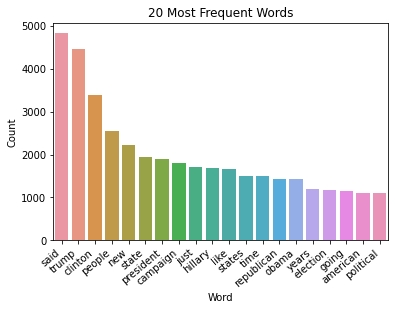

<Figure size 720x288 with 0 Axes>

In [15]:
train_count = pd.DataFrame(train_count_dic.items(), columns=['Word', 'Count'])
train_count = train_count.sort_values(by=['Count'],ascending=False)
train_count_20 = train_count.head(20)
# Let's just look at the top 20
tc20 = sns.barplot(x="Word", y="Count", data=train_count_20)
tc20.set_xticklabels(tc20.get_xticklabels(), rotation=40, ha="right")
tc20.set_title("20 Most Frequent Words")
plt.figure(figsize=(10,4))
plt.tight_layout()
plt.show()

In [16]:
train_count_20

,Word,Count
29643,said,4828
35099,trump,4469
5975,clinton,3394
24938,people,2560
22708,new,2229
32408,state,1948
26326,president,1887
4721,campaign,1810
18286,just,1716
15534,hillary,1691


We get a general idea of the top 20 words in our dataset.

You can probably start seeing where things might get a bit choppy. Keywords like 'trump' despite any controversy associated will not be enough to establish 'Fake News' as both true and false information is reported regarding him. Likewise, the word 'said' is the most common word, despite having little meaning. We resolve that later.

 Let's not also forget the test set.

In [17]:
testing_data['text'] = testing_data['text'].apply(lambda x: cleantext(x))

#### On the topic of 'scaling'

Another important consideration is what we discovered before. Words like 'Trump' get repeated quite often. This will cause issues in analysis.

Instead, we could consider tfidf, which establishes 'term frequency times inverse-document frequency'.

This is to say: 

>The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

From: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

Which is to say that we are effectively scaling word frequency so less emphasis is placed on words that are too common. 

#### Remove 'said' from acceptable word list. (This actually has minimum impact, strangely)

Here we add the word 'said' to the 'stop_words'. This effectively removes it from consideration in analysis.

In [18]:
stop_words = set(text.ENGLISH_STOP_WORDS).union('said')
stop_words.add('said')
stop_words

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'bill',
 'both',
 'bottom',
 'but',
 'by',
 'call',
 'can',
 'cannot',
 'cant',
 'co',
 'con',
 'could',
 'couldnt',
 'cry',
 'd',
 'de',
 'describe',
 'detail',
 'do',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eg',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'etc',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'fill',
 'find',
 'fire',
 'first',
 'five',


#### More Pythonic Means of getting vector counts

Here we just create a function to run both the original count vectorizer we were using before, and the aforementioned tfidf transformer that allows us to scale back on the impact of high frequency terms like 'trump'.

In [19]:
def extract_features(data,X_train,X_test,type="count"):        
    if "count" in type:        
        v = CountVectorizer(stop_words=stop_words,analyzer='word')
        v.fit_transform(X_train)
        
        v_train_set= v.transform(training_data['text'].values)
        v_test_set= v.transform(testing_data['text'].values)
        
        return v_train_set,v_test_set,v 
    else:    
        
        tfidf_v =TfidfVectorizer(use_idf=True,stop_words=stop_words,analyzer='word')
        tfidf_v.fit_transform(X_train)
        
        tfidf_train_set =tfidf_v.transform(training_data['text'].values)
        tfidf_test_set =tfidf_v.transform(testing_data['text'].values)
        
        return tfidf_train_set,tfidf_test_set,tfidf_v

### Training/Predicting with Model

For this project, I wanted to use the simplest supervised model I could think of for the task. I wanted to give an interpretable result and also understand what could be happening underneath.

The predicted variable in this case is also binary, leaving it as a perfect fit for a logistic regression model.

In [20]:
vec_train,vec_test,feature_transformer=extract_features(data,training_data['text'],testing_data['text'],type="count")
tf_train,tf_test,feature_transformer=extract_features(data,training_data['text'],testing_data['text'],type="tfidf")

In [21]:
logreg = LogisticRegression(verbose=1, solver='liblinear',random_state=1, C=5, penalty='l2',max_iter=100)
lr_model_vc = logreg.fit(vec_train,y_train)

[LibLinear]

In [22]:
type(vec_train)

scipy.sparse.csr.csr_matrix

#### Here we train the 'normal' count model that doesn't take into account scaling for abnormally high word frequencies.

In [23]:
lr_predictions_vc = lr_model_vc.predict(vec_test)
lr_model_vc.score(vec_test,y_test)
#eval_perf = collect_preds(y_test,lr_predictions)
#accuracy=compute_accuracy(eval_perf)
#mrr_lr =compute_mrr(eval_perf)

0.90311986863711

#### The model has a 90.3 % prediction accuracy on the test data.

#### And here we train the model that scales for high word frequencies

In [24]:
lr_model_tf = logreg.fit(tf_train,y_train)
lr_predictions_tf = lr_model_tf.predict(tf_test)
lr_model_tf.score(tf_test,y_test)

[LibLinear]

0.9293924466338259

#### As expected, this produces a model with a higher accuracy of 93%.

We then take a look at other measures of performance including 'AUC' or 'Area Under the Curve'. This looks to qualify model predictive accuracy through performance on true positive rates and false positive rates.

In [25]:
y_prob = lr_model_vc.predict_proba(vec_train)[:,1]

In [26]:
fpr, tpr, thresholds = roc_curve(y_train, y_prob,pos_label='REAL')
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.964735020291239


Our model seems to be able to robustly predict accurately without high levels of false positives from the data given.

### Conclusions

Our model performed excellently, able to accurately predict 'fake' or 'real' news at a rate of 90% without considering scaling of frequent words, and 93% upon consideration of scaling of more frequent words. Likewise, this was accompanied by a high AUC score, indicating that the model was correctly predicting labels.

These results are a little surprising to me given the relative dearth of information available to the model and relatively small sample size for the model to train off of. I suspect that the model may have been overfitted to the data presented. Given the relatively high frequency of various politically charged terms, it's possible that the data used drastically distinct examples of 'fake news', while using more 'normal' text for 'real' news.

To test this theory, let's look at the distribution of words under each label.

In [27]:
realdata = data[data['label'] == 'REAL']
realdata['text'] = realdata['text'].apply(lambda x: cleantext(x))
fakedata = data[data['label'] == 'FAKE']
fakedata['text'] = fakedata['text'].apply(lambda x: cleantext(x))

<ipython-input-27-607fd4164678>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  realdata['text'] = realdata['text'].apply(lambda x: cleantext(x))
<ipython-input-27-607fd4164678>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fakedata['text'] = fakedata['text'].apply(lambda x: cleantext(x))


['aaa' 'aalia' 'aaron' ... 'zucker' 'zuckerberg' 'zuma']


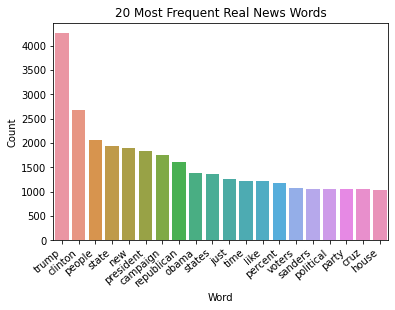

<Figure size 720x288 with 0 Axes>

In [28]:
vectorizer = CountVectorizer(stop_words=stop_words,analyzer='word')
real_vec = vectorizer.fit_transform(realdata['text'].values)
features = vectorizer.get_feature_names_out() #Shows word tokens
print(features)
features.shape
count_list = real_vec.toarray().sum(axis=0)
real_count_dic = dict(zip(features,count_list))
real_count = pd.DataFrame(real_count_dic.items(), columns=['Word', 'Count'])
real_count = real_count.sort_values(by=['Count'],ascending=False)
real_count_20 = real_count.head(20)
# Let's just look at the top 20
real20 = sns.barplot(x="Word", y="Count", data=real_count_20)
real20.set_xticklabels(real20.get_xticklabels(), rotation=40, ha="right")
real20.set_title("20 Most Frequent Real News Words")
plt.figure(figsize=(10,4))
plt.tight_layout()
plt.show()

In [29]:
real_count.head(50)

,Word,Count
27083,trump,4258
4605,clinton,2687
19070,people,2062
24903,state,1938
17399,new,1907
20099,president,1844
3614,campaign,1759
21826,republican,1601
17854,obama,1394
24923,states,1370


['aa' 'aaaa' 'aaaaadd' ... 'zucman' 'zuesse' 'zulu']


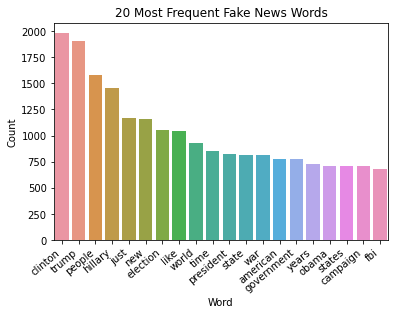

<Figure size 720x288 with 0 Axes>

In [30]:
vectorizer = CountVectorizer(stop_words=stop_words,analyzer='word')
fake_vec = vectorizer.fit_transform(fakedata['text'].values)
features = vectorizer.get_feature_names_out() #Shows word tokens
print(features)
features.shape
count_list = fake_vec.toarray().sum(axis=0)
fake_count_dic = dict(zip(features,count_list))
fake_count = pd.DataFrame(fake_count_dic.items(), columns=['Word', 'Count'])
fake_count = fake_count.sort_values(by=['Count'],ascending=False)
fake_count_20 = fake_count.head(20)
# Let's just look at the top 20
fake20 = sns.barplot(x="Word", y="Count", data=fake_count_20)
fake20.set_xticklabels(fake20.get_xticklabels(), rotation=40, ha="right")
fake20.set_title("20 Most Frequent Fake News Words")
plt.figure(figsize=(10,4))
plt.tight_layout()
plt.show()

In [31]:
fake_count.head(50)

,Word,Count
4901,clinton,1981
28650,trump,1908
20355,people,1580
12678,hillary,1456
15060,just,1171
18574,new,1159
8692,election,1049
16072,like,1045
30880,world,924
28089,time,848


As one would suspect, there are differences in representation of words between the two news labels. However, there exists enough overlap to show that it's unlikely that the two labeled texts drastically differed as to be about completely different topics (real news being about kittens, while fake news being about vaccines, for example).

Surprisingly, without a need to consider word pair relations or other such features outside of individual counts of words, it looks as though our classification model was able to strongly predict fake news within this dataset. This implies that usage and frequency of certain key words alone could be enough to detect potential proliferation of misinformation.

## Next Steps

Next steps would have to include:

#### Validating that the model can perform on other data.

It's possible that my model would not be able to perform well outside of this tailored dataset. There is 20 MB more data to potentially validate my model on, but my thoughts are that data from other sources should also be considered.

#### Observing impacts of connectiveness of words in determining whether or not they were 'fake news' dependent. 

Just looking over some of the more frequent words, it's evident that there may be further information for a model to work with through word associations and pairs. "emails" or "day" alone may have little meaning, but likely were also paired with words like 'Hilary' or 'election', for example.

#### Looking deeper into the model to see what features were most salient.

With more time, and a greater understanding of sklearn's logistic regression, and logistic regression in general, I will be better be able to interpret my model results, and perhaps learn whether it was overfitted to the data through a certain parameter.